In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.measure import label, regionprops



In [5]:
!pip install opencv-python


In [6]:
import zipfile
import os

ZIP_PATH = "/content/archive.zip"

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("/content")


In [7]:
import os

BASE_PATH = "/content"

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "Train", "image")
TRAIN_MASK_PATH = os.path.join(BASE_PATH, "Train", "label")

VAL_IMG_PATH = os.path.join(BASE_PATH, "Validation", "image")
VAL_MASK_PATH = os.path.join(BASE_PATH, "Validation", "label")



In [8]:
#Alegem patch_size=32, stride=32 doar pentru antrenare,
# iar pentru test patch_size=32, stride=16 penntru ca
# fiecrae pixel e votat de mai multe patchuri (IoU mai mare)
def extract_patches(img, patch_size=32, stride=32):

      # - patches: listă de patch-uri (patch_size x patch_size x 3)
      # - positions: poziția (y, x) a fiecărui patch în imagine
      #              pentru a putea reconstruii masca finala

    H, W, _ = img.shape
    patches = []
    positions = []

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
           #extrage efectiv patchul
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            positions.append((y, x))

    return np.array(patches), positions

def label_patches(positions, mask, patch_size=32, threshold=0.15):
    """
    positions: listă de (y, x) pentru fiecare patch
    mask: mască binară (H, W), 1 = drum, 0 = fundal
    patch_size: dimensiunea patch-ului
    threshold: procent minim de pixeli drum pentru a eticheta patch-ul ca drum
    """
    labels = []

    for (y, x) in positions:
        patch_mask = mask[y:y+patch_size, x:x+patch_size]
        ratio = np.mean(patch_mask)  # procent pixeli drum
        # ≥ 15% din patch e drum → patch = drum
        if ratio >= threshold:
            labels.append(1)
        else:
            labels.append(0)

    return np.array(labels)



 alegem o imagine de train pe care o impartim pentr vizualizare

In [9]:

img_name = sorted(os.listdir(TRAIN_IMG_PATH))[0]
img_path = os.path.join(TRAIN_IMG_PATH, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

patches, positions = extract_patches(img, patch_size=32, stride=32)

print("Număr patch-uri:", patches.shape[0])
print("Dimensiune patch:", patches.shape[1:])


Număr patch-uri: 432
Dimensiune patch: (32, 32, 3)


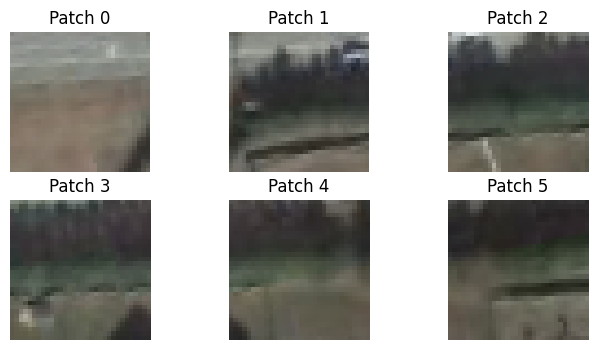

In [10]:
plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(patches[i])
    plt.title(f"Patch {i}")
    plt.axis("off")
plt.show()


Impartim toate pozele din train in patch uri

In [11]:
#pentru train
PATCH_SIZE = 32
STRIDE = 32

X_train = []
y_train = []

train_images = sorted(os.listdir(TRAIN_IMG_PATH))
train_masks  = sorted(os.listdir(TRAIN_MASK_PATH))

for img_name, mask_name in zip(train_images, train_masks):

    img_path = os.path.join(TRAIN_IMG_PATH, img_name)
    mask_path = os.path.join(TRAIN_MASK_PATH, mask_name)

    # citire imagine
    img = cv2.imread(img_path)
    # OpenCV folosește BGR
    # Matplotlib, TensorFlow, CNN-urile se așteaptă la RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # fiecare pixel devine float
    # interval: 0.0 – 1.0
    img = img / 255.0


    # citire mască
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.uint8)

    # patch extraction
    patches, positions = extract_patches(img, PATCH_SIZE, STRIDE)

    # etichetare patch-uri
    labels = label_patches(positions, mask, PATCH_SIZE)

    X_train.append(patches)
    y_train.append(labels)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

print("Total patch-uri:", X_train.shape)
print("Total etichete:", y_train.shape)


Total patch-uri: (108739, 32, 32, 3)
Total etichete: (108739,)


In [12]:
#pentru validare
PATCH_SIZE = 32
STRIDE = 32

X_val = []
y_val = []

val_images = sorted(os.listdir(VAL_IMG_PATH))
val_masks  = sorted(os.listdir(VAL_MASK_PATH))

for img_name, mask_name in zip(val_images, val_masks):

    img_path = os.path.join(VAL_IMG_PATH, img_name)
    mask_path = os.path.join(VAL_MASK_PATH, mask_name)

    # imagine
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0

    # mască
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.uint8)

    # patch-uri
    patches, positions = extract_patches(img, PATCH_SIZE, STRIDE)
    labels = label_patches(positions, mask, PATCH_SIZE)

    X_val.append(patches)
    y_val.append(labels)

X_val = np.vstack(X_val)
y_val = np.hstack(y_val)

print("VAL patches:", X_val.shape)
print("VAL labels:", y_val.shape)


VAL patches: (9267, 32, 32, 3)
VAL labels: (9267,)


In [13]:
def show_patches(patches, indices, title, n=6):
    plt.figure(figsize=(8,4))

    chosen = np.random.choice(indices, size=min(n, len(indices)), replace=False)

    for i, idx in enumerate(chosen):
        plt.subplot(2, 3, i+1)
        plt.imshow(patches[idx])
        plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()


In [14]:
road_indices_train = np.where(y_train == 1)[0]
nonroad_indices_train = np.where(y_train == 0)[0]

print("TRAIN – patch-uri drum:", len(road_indices_train))
print("TRAIN – patch-uri non-drum:", len(nonroad_indices_train))


TRAIN – patch-uri drum: 28781
TRAIN – patch-uri non-drum: 79958


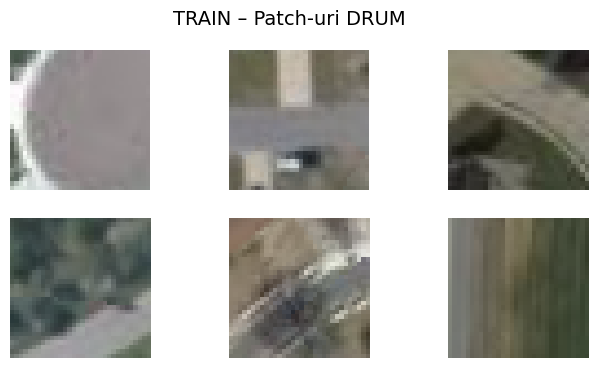

In [15]:
show_patches(
    X_train,
    road_indices_train,
    title="TRAIN – Patch-uri DRUM",
    n=6
)

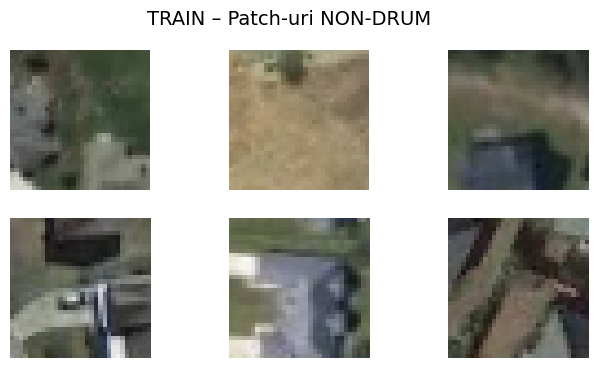

In [16]:
show_patches(
    X_train,
    nonroad_indices_train,
    title="TRAIN – Patch-uri NON-DRUM",
    n=6
)

Impartim datele de train in date cu care antrenam si date prin care validam antrenarea

In [17]:
pip install tensorflow


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [19]:
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Flatten, Dense, Dropout, Input
)
from tensorflow.keras.models import Model

inputs = Input(shape=(32, 32, 3))

# ===== Encoder =====
c1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
c1 = Conv2D(16, (3,3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D(2)(c1)   # 16x16

c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
c2 = Conv2D(32, (3,3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D(2)(c2)   # 8x8

# ===== Bottleneck =====
b = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
b = Conv2D(64, (3,3), activation='relu', padding='same')(b)

# ===== Decoder =====
u1 = UpSampling2D(2)(b)    # 16x16
u1 = Concatenate()([u1, c2])
d1 = Conv2D(32, (3,3), activation='relu', padding='same')(u1)

u2 = UpSampling2D(2)(d1)   # 32x32
u2 = Concatenate()([u2, c1])
d2 = Conv2D(16, (3,3), activation='relu', padding='same')(u2)

# ===== Feature head (pentru SVM) =====
f = Flatten()(d2)
f = Dense(128, activation='relu')(f)
f = Dropout(0.5)(f)
output = Dense(1, activation='sigmoid')(f)

cnn = Model(inputs, output)


In [20]:
cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
#Loss – Binary Crossentropy
#L = -[y log(p) + (1-y) log(1-p)]


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0,1]),
    y=y_train
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)


{0: np.float64(0.6799757372620626), 1: np.float64(1.889076126611306)}


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    class_weight=class_weights,
    shuffle=True,
    callbacks=[early_stop]
)


Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 520s 603ms/step - accuracy: 0.7679 - loss: 0.4296 - val_accuracy: 0.7147 - val_loss: 0.7430
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 545s 584ms/step - accuracy: 0.8860 - loss: 0.2571 - val_accuracy: 0.8459 - val_loss: 0.3064
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 513s 598ms/step - accuracy: 0.9316 - loss: 0.1720 - val_accuracy: 0.9062 - val_loss: 0.2553
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 552s 586ms/step - accuracy: 0.9475 - loss: 0.1391 - val_accuracy: 0.9313 - val_loss: 0.1729
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 509s 594ms/step - accuracy: 0.9521 - loss: 0.1237 - val_accuracy: 0.9316 - val_loss: 0.1638
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 511s 602ms/step - accuracy: 0.9570 - loss: 0.1137 - val_accuracy: 0.9294 - val_loss: 0.1928
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 555s 594ms/step - accuracy: 0.9590 - loss: 0.1075 - val_accuracy: 0.9250 - val_loss: 0.1902


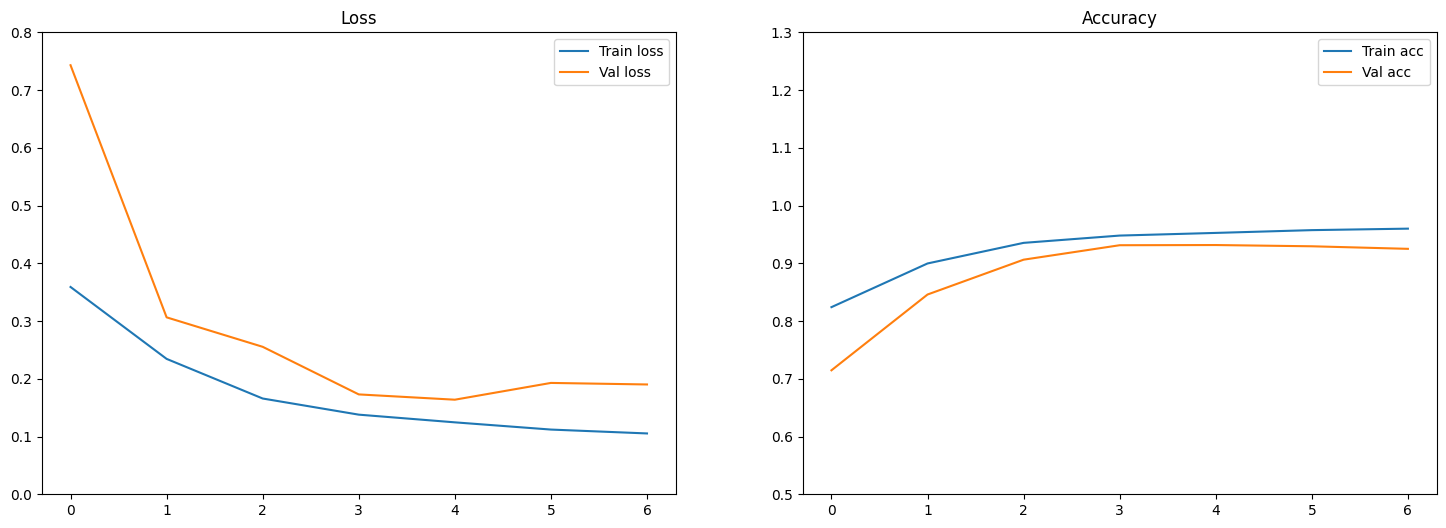

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.ylim(0, 0.8)
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.ylim(0.50, 1.3)
plt.legend()
plt.title("Accuracy")

plt.show()


cream un model nou pentru a extra

In [25]:
feature_extractor = tf.keras.Model(
    inputs=cnn.input,
    outputs=cnn.layers[-2].output
)


In [26]:
Xf_train = feature_extractor.predict(X_train, batch_size=256)
Xf_val   = feature_extractor.predict(X_val, batch_size=256)


425/425 ━━━━━━━━━━━━━━━━━━━━ 129s 302ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step


SVM este foarte sensibil la scalare, asa ca normalizarea este obligatorie

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xf_train = scaler.fit_transform(Xf_train)
Xf_val   = scaler.transform(Xf_val)


In [28]:
from sklearn.svm import SVC

svm = SVC(
    kernel='linear',
    probability=True,
    class_weight='balanced'
)

from sklearn.utils import resample

# separăm clasele
X0 = Xf_train[y_train == 0]
X1 = Xf_train[y_train == 1]

# sub-sampling
N = 20000
X0_sub = resample(X0, n_samples=N, random_state=42)
X1_sub = resample(X1, n_samples=N, random_state=42)

Xf_train_sub = np.vstack([X0_sub, X1_sub])
yf_train_sub = np.array([0]*N + [1]*N)

svm.fit(Xf_train_sub, yf_train_sub)


SVC(class_weight='balanced', kernel='linear', probability=True)

In [29]:
from sklearn.metrics import classification_report

y_pred = svm.predict(Xf_val)
print(classification_report(y_val, y_pred, target_names=["non-drum", "drum"]))


              precision    recall  f1-score   support

    non-drum       0.98      0.90      0.94      6173
        drum       0.83      0.96      0.89      3094

    accuracy                           0.92      9267
   macro avg       0.91      0.93      0.92      9267
weighted avg       0.93      0.92      0.93      9267



Rezultate obtinute pe datele train de validare

**recall** = 0.94
94% din patch-urile care CHIAR sunt drum au fost detectate ca drum

mai bine se marcheaza puțin în plus,
decât să ratezi bucăți de drum


 **precision** = 0.77
Din toate patch-urile prezise ca „drum”, 77% chiar sunt drum

există ceva false positives

ex: parcări, acoperișuri gri, trotuare

In [49]:
TEST_IMG_PATH = os.path.join(BASE_PATH, "Test", "image")
TEST_MASK_PATH = os.path.join(BASE_PATH, "Test", "label")

test_images = sorted(os.listdir(TEST_IMG_PATH))
img_name = test_images[0]

img_path = os.path.join(TEST_IMG_PATH, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

H, W, _ = img.shape


In [50]:
PATCH_SIZE = 32
STRIDE = 16

patches, positions = extract_patches(img, PATCH_SIZE, STRIDE)

print("Număr patch-uri test:", patches.shape[0])


Număr patch-uri test: 2800


In [51]:
patch_features = feature_extractor.predict(patches, batch_size=256)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step


In [52]:
patch_features_scaled = scaler.transform(patch_features)

patch_preds = svm.predict_proba(patch_features_scaled)[:, 1]


In [53]:
score_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.float32)

for (y, x), pred in zip(positions, patch_preds):
    score_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE] += pred
    count_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE] += 1

road_mask = (score_map / (count_map + 1e-6)) > 0.6


In [54]:
road_mask = road_mask.astype(np.uint8)

kernel = np.ones((3,3), np.uint8)
road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, kernel)



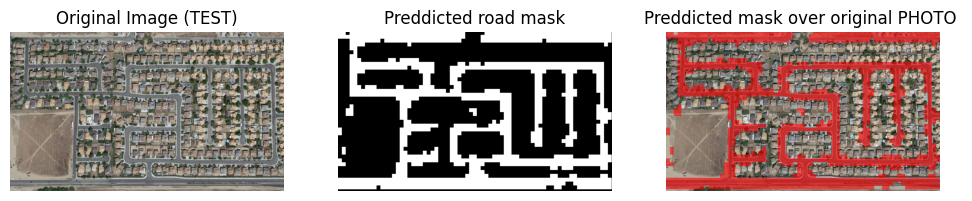

In [56]:
h_mask, w_mask = road_mask.shape
img_crop = img[:h_mask, :w_mask]

overlay = img_crop.copy()
overlay[road_mask == 1] = [1, 0, 0]  # roșu pentru drum

alpha = 0.6
result = (alpha * overlay + (1 - alpha) * img_crop)

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.imshow(img_crop)
plt.title("Original Image (TEST)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(road_mask, cmap="gray")
plt.title("Preddicted road mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(result)
plt.title("Preddicted mask over original PHOTO ")
plt.axis("off")

plt.show()


In [57]:
def predict_road_map(img,
                      feature_extractor, svm, scaler,
                      patch_size=32, stride=16, vote_thresh=0.9):

    H, W, _ = img.shape

    patches, positions = extract_patches(img, patch_size, stride)

    feats = feature_extractor.predict(patches, batch_size=256)
    feats = scaler.transform(feats)

    preds = svm.predict_proba(feats)[:, 1]

    score_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)

    for (y, x), p in zip(positions, preds):
        score_map[y:y+patch_size, x:x+patch_size] += p
        count_map[y:y+patch_size, x:x+patch_size] += 1

    road_mask = (score_map / (count_map + 1e-6)) > vote_thresh
    return road_mask.astype(np.uint8)


def compute_iou(pred_mask, gt_mask):
    pred = pred_mask.astype(bool)
    gt = gt_mask.astype(bool)

    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()

    if union == 0:
        return 1.0  # caz trivial
    return intersection / union



In [58]:
ious = []

img_names = sorted(os.listdir(VAL_IMG_PATH))
mask_names = sorted(os.listdir(VAL_MASK_PATH))

for img_name, mask_name in zip(img_names, mask_names):

    img = cv2.imread(os.path.join(VAL_IMG_PATH, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0

    gt_mask = cv2.imread(os.path.join(VAL_MASK_PATH, mask_name),
                          cv2.IMREAD_GRAYSCALE)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    pred_mask = predict_road_map(
        img,
        feature_extractor,
        svm,
        scaler,
        patch_size=32,
        stride=16,
        vote_thresh=0.65
    )

    iou = compute_iou(pred_mask, gt_mask)
    ious.append(iou)

print(f"Mean IoU: {np.mean(ious):.3f}")
print(f"Std IoU:  {np.std(ious):.3f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step
Mean IoU: 0.382
Std IoU:  0.040
